# CNN with ResNet for CIFAR-10

In [11]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
import tqdm

In [12]:
# Creating the datasets and applying transformations

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

testing_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=val_transform,
)

# setting a training/validation split of 80-20
train_size = .8*len(training_data)
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [int(train_size), int(val_size)])

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = val_transform

Files already downloaded and verified
Files already downloaded and verified


Visualizing loaded CIFAR10 data

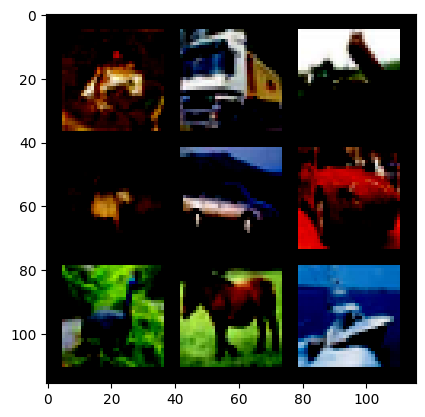

In [13]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

# Model

In [ ]:
# Initialize the weights of the model using Xavier initialization
def xavier_init(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)  # Xavier initialization for weights
        if model.bias is not None:
            nn.init.zeros_(model.bias)  # Initialize bias to zero

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        conv1_out = 64
        res1_out = 64
        res2_out = 128
        res3_out = 256

        # Initial convolution layer with batch normalization and max pooling
        self.dropout = nn.Dropout(p=0.6)
        self.conv1 = nn.Conv2d(3, conv1_out, 3, 1, 1, bias=False)
        self.bn = nn.BatchNorm2d(conv1_out)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define three residual blocks with increasing number of filters
        self.myRes1 = nn.Sequential(
            nn.Conv2d(conv1_out, res1_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res1_out),
            nn.ReLU(),
            nn.Conv2d(res1_out, res1_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res1_out),
        )
        self.myRes2 = nn.Sequential(
            nn.Conv2d(res1_out, res2_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res2_out),
            nn.ReLU(),
            nn.Conv2d(res2_out, res2_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res2_out),
        )
        self.myRes3 = nn.Sequential(
            nn.Conv2d(res2_out, res3_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res3_out),
            nn.ReLU(),
            nn.Conv2d(res3_out, res3_out, 3, 1, 1, bias=False),
            nn.BatchNorm2d(res3_out),
        )

        # Downsampling layers for skip connections in residual blocks
        self.oneByOne_downsample1 = nn.Conv2d(conv1_out, res1_out, 1, 1, bias=False)
        self.oneByOne_downsample2 = nn.Conv2d(res1_out, res2_out, 1, 1, bias=False)
        self.oneByOne_downsample3 = nn.Conv2d(res2_out, res3_out, 1, 1, bias=False)

        # Average pooling and fully connected layer for classification
        self.averagePool = torch.nn.AvgPool2d(2)
        self.fullyConnected = nn.Linear(res3_out, 10)

    def forward(self, x):
        # Initial convolution + batch norm + ReLU + max pooling
        out = self.conv1(x)
        out = self.bn(out)
        out = torch.nn.functional.relu(out)
        out = self.maxpool(out)

        # Residual block 1 with skip connection
        skip_x = out
        out = self.myRes1(out)
        ds_skip = self.oneByOne_downsample1(skip_x)
        out = torch.nn.functional.relu(out + ds_skip)
        out = self.maxpool(out)

        # Residual block 2 with skip connection
        skip_x = out
        out = self.myRes2(out)
        ds_skip = self.oneByOne_downsample2(skip_x)
        out = torch.nn.functional.relu(out + ds_skip)
        out = self.maxpool(out)

        # Residual block 3 with skip connection
        skip_x = out
        out = self.myRes3(out)
        ds_skip = self.oneByOne_downsample3(skip_x)
        out = torch.nn.functional.relu(out + ds_skip)
        out = self.maxpool(out)

        # Global average pooling, flattening, dropout, and fully connected layer
        out = self.averagePool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.dropout(out)
        y = self.fullyConnected(out)
        return y

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

# Hyperparameters
epochs = 10
batch_size = 64
learning_rate = 0.001

# Initialize model and apply Xavier initialization
model = ResNet().to(device)
xavier_init(model)

# Define optimizer, learning rate scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Create data loaders for training, validation, and testing
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Lists for plotting losses
plt_VL = []  # Validation loss
plt_TL = []  # Training loss

model.train()  # Put model in training mode
for epoch in range(epochs):
    # Training phase
    training_losses = []
    train_correct = 0
    for x, y in tqdm.tqdm(train_dataloader, unit="batch"):
        x, y = x.float().to(device), y.long().to(device)
        optimizer.zero_grad()  # Clear previous gradients
        pred = model(x)
        train_correct += (torch.argmax(pred, dim=1) == y).sum().item()  # Count correct predictions
        loss = criterion(pred, y)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
        training_losses.append(loss.item())

    # Validation phase
    val_correct = 0
    val_losses = []
    for x, y in val_dataloader:
        x, y = x.float().to(device), y.long().to(device)
        pred = model(x)
        loss = criterion(pred, y)
        val_correct += (torch.argmax(pred, dim=1) == y).sum().item()  # Count correct predictions
        val_losses.append(loss.item())

    # Compute and display accuracies and losses for this epoch
    train_accuracy = (train_correct / len(train_dataset)) * 100
    val_accuracy = (val_correct / len(val_dataset)) * 100
    print(f"Epoch {epoch + 1}, val accuracy: {val_accuracy:.2f}%, train accuracy: {train_accuracy:.2f}%, val loss: {np.mean(val_losses):.4f}, training loss: {np.mean(training_losses):.4f}")
    plt_VL.append(np.mean(val_losses))
    plt_TL.append(np.mean(training_losses))
    model.train()  # Put model back in training mode
    scheduler.step()  # Adjust learning rate

# Compute final test accuracy
with torch.no_grad():
    model.eval()  # Put model in evaluation mode
    num_correct = 0
    for x, y in test_dataloader:
        x, y = x.float().to(device), y.long().to(device)
        pred = model(x)
        num_correct += (torch.argmax(pred, dim=1) == y).sum().item()
    print("Final Accuracy:", num_correct / len(testing_data) * 100)
    model.train()  # Put model back in training mode



Using device cuda


100%|██████████| 625/625 [00:17<00:00, 35.29batch/s]


Epoch 1,
             val accuracy: 65.54%, 
             train accuracy: 53.01%, 
             val loss: 0.9897             training loss: 1.3073


100%|██████████| 625/625 [00:13<00:00, 44.85batch/s]


Epoch 2,
             val accuracy: 73.06%, 
             train accuracy: 70.20%, 
             val loss: 0.7930             training loss: 0.8605


100%|██████████| 625/625 [00:13<00:00, 44.86batch/s]


Epoch 3,
             val accuracy: 76.08%, 
             train accuracy: 76.48%, 
             val loss: 0.7087             training loss: 0.6872


100%|██████████| 625/625 [00:14<00:00, 44.19batch/s]


Epoch 4,
             val accuracy: 78.76%, 
             train accuracy: 80.22%, 
             val loss: 0.6426             training loss: 0.5826


100%|██████████| 625/625 [00:14<00:00, 44.49batch/s]


Epoch 5,
             val accuracy: 80.86%, 
             train accuracy: 83.06%, 
             val loss: 0.5935             training loss: 0.5041


100%|██████████| 625/625 [00:14<00:00, 44.29batch/s]


Epoch 6,
             val accuracy: 79.99%, 
             train accuracy: 85.15%, 
             val loss: 0.6066             training loss: 0.4403


100%|██████████| 625/625 [00:14<00:00, 44.52batch/s]


Epoch 7,
             val accuracy: 80.88%, 
             train accuracy: 86.97%, 
             val loss: 0.5859             training loss: 0.3906


100%|██████████| 625/625 [00:14<00:00, 43.77batch/s]


Epoch 8,
             val accuracy: 81.56%, 
             train accuracy: 88.31%, 
             val loss: 0.5974             training loss: 0.3445


100%|██████████| 625/625 [00:14<00:00, 44.24batch/s]


Epoch 9,
             val accuracy: 81.66%, 
             train accuracy: 89.56%, 
             val loss: 0.5922             training loss: 0.3068


100%|██████████| 625/625 [00:13<00:00, 44.77batch/s]


Epoch 10,
             val accuracy: 82.28%, 
             train accuracy: 91.05%, 
             val loss: 0.6144             training loss: 0.2620
Final Accuracy: 0.8208


Plot training and validation loss

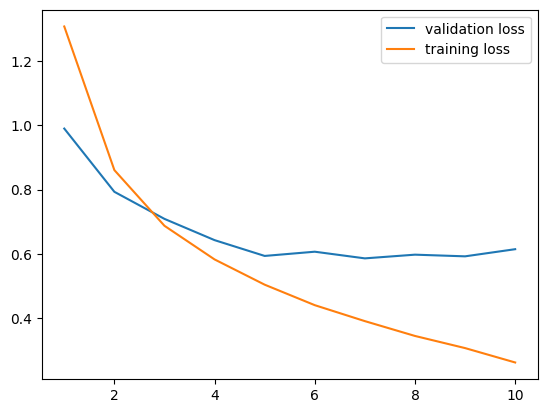

In [14]:
import matplotlib.pyplot as plt
x = np.arange(1,11,1)
plt.plot(x, plt_VL, label="validation loss")
plt.plot(x, plt_TL, label="training loss")
plt.legend()

Prepare CIFAR10 test dataset

In [48]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the same transformations as used during training and validation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to match training preprocessing
])

# Load the CIFAR-10 test set
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory to store the dataset
    train=False,    # This ensures we get the test set
    download=True,  # Download if not already available
    transform=transform
)

# Create a DataLoader for the test set
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


Calculate test accuracy

In [28]:
# Assuming 'model' and 'device' are already defined
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 82.08%


Display random image from test set alongside its true and predicted class values

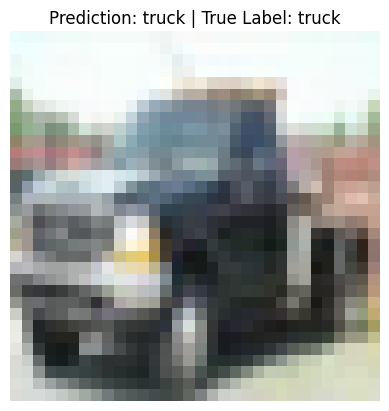

In [47]:
import random
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_random_prediction():
    # Randomly select an index from the test dataset
    index = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[index]

    # Convert the image back to [0, 1] range for display
    img_display = img * 0.5 + 0.5  # Undo normalization
    img_display = img_display.permute(1, 2, 0).numpy()  # Change to HWC format for plotting

    # Get the model's prediction
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = classes[predicted.item()]
    true_label = classes[label]

    # Display the image and classification
    plt.imshow(img_display)
    plt.title(f'Prediction: {predicted_label} | True Label: {true_label}')
    plt.axis('off')
    plt.show()

# Call the function to show a random prediction
show_random_prediction()

Congrats! You made it to the end.